In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Includes

In [ ]:
! pip install git+https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import time 
import pandas as pd
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals
import os
import matplotlib.pyplot as plt
from io import BytesIO
from functools import partial    
import scipy.io as sio 
import time  
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-1npp4v80
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-1npp4v80
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=31432 sha256=914c320337981095c595329c8316782f291da656ce83a1b08dfb74287f411c2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ai3qx2gz/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip 'Datasets.zip'

Archive:  /content/drive/My Drive/Diploma/simple_code.zip
  inflating: models.py               
  inflating: simple_static.py        
  inflating: wenting_data.mat        


# Data preprocessor

In [ ]:
def Normalize(train_data, eps=1e-12):
    """Standard Normalization of data"""
    return (train_data - train_data.mean(0, keepdims=True))/torch.sqrt(train_data.var(0, keepdims=True)+eps)

def NoRmalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [ ]:
def load_data(w, test_names):
    """Load data from .mat file"""
    data = sio.loadmat('wenting_data.mat')
    train_x = (data['Y'][:, w] @ data['training_dV'][w, :]).imag.T
    Nx = data['training_dV'].shape[0] # Number of buses
    Nfault = data['training_dV'].shape[1] # Number of faults
    Ny = max(max(data['training_y_num'])) + 1 # Number of fault locations + 1
    train_y = np.zeros((Nfault, Ny+1))
    for i in range(Nfault):
        train_y[i, data['training_y_num'][0][i] ] = 1
    A = data['A']
    A = NoRmalize(A + np.eye(A.shape[0]))
    k = 0
    for name in test_names:
        test_x = (data['Y'][:, w] @ data[name+'_dV'][w, :]).imag.T
        Nfault = data[name+'_dV'].shape[1] # Number of faults
        test_y = np.zeros((Nfault, Ny))
        for i in range(Nfault):
            test_y[i, data[name+'_y_num'][0][i]] = 1
        test_x = torch.FloatTensor(test_x.reshape([test_x.shape[0], 1, Nx]))
        test_y = torch.LongTensor(test_y)
        if k==0:
            Test_x = test_x.clone()
            Test_y = test_y.clone()
        else:
            Test_x = torch.cat((Test_x, test_x), dim=0)
            Test_y = torch.cat((Test_y, test_y), dim=0)
        k+=1
    train_x = torch.FloatTensor(train_x.reshape([train_x.shape[0], 1, Nx]))
    A = torch.FloatTensor(A)
    train_y = torch.LongTensor(train_y)
    return train_x, train_y, Test_x, Test_y, A, Nx, Ny

# Models

## Linear Regression

In [ ]:
class LR(nn.Module):
    def __init__(self, nin, nout):
        super(LR, self).__init__()
        self.LR = nn.Linear(nin, nout)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LR(x)
        return x

## FeedForward NN

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, nin, nhid, nout):
        super(FeedForward, self).__init__()
        self.NN = nn.Sequential(nn.Linear(nin, nhid), nn.ReLU(), nn.Linear(nhid, nout))
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.NN(x)
        return x

## AlexNet

Here we construct exactly the same model as was used in https://arxiv.org/abs/1810.05247

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, outdim):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(4, 8, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(8, 8, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(8, 8, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(16, outdim),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

## GraphConvNN

Ref: https://arxiv.org/abs/1609.02907

In [ ]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, adj, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.adj = adj.to(device)
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        support = torch.einsum('zx,iyx->izy', (self.adj, input))
        output = torch.einsum('xz,izy->ixy', (self.weight, support))
        output = output.permute(0, 2, 1)
        return output

class GCNN(nn.Module):
    def __init__(self, nin, nhid, nout, adj, dropout):
        super(GCNN, self).__init__()

        self.gc1 = GraphConvolution(nin, nhid, adj)
        self.classifier = nn.Sequential(
            nn.Linear(nhid, nout),
        )
        self.dropout = dropout
        
    def forward(self, x):
        x = F.relu(self.gc1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## ODE NN

In [ ]:
class GCDEFunc(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, adj, type):#, dropout:float):
        """Standard GCDN ODE function class. To be passed to an ODEBlock"""
        super().__init__()
        if type == 'Graph':
          self.l = GraphConvolution(input_dim, hidden_dim, adj)
        if type == 'Linear':
          self.l = nn.Linear(input_dim, hidden_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        x = F.relu(self.l(x))
        return x

In [ ]:
import torch
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-3, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
        out = torch.flatten(out[-1], 1)
        return out
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, t_end, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

# Model for bus importance

In [ ]:
class Model_BI(nn.Module):
    """Model for mapping observed busses to the accuracy of the optimized model"""
    def __init__(self, nhid, nout, adj, dropout):
        super(Model_BI, self).__init__()

        self.layer1 = nn.Sequential(
            GraphConvolution(68, nhid, adj),
            nn.ReLU()
        )
        self.layermid1 = nn.Sequential(
            nn.Linear(nhid, nhid),
            nn.ReLU()
        )

        self.layermid2 = nn.Sequential(
            nn.Linear(nhid, nhid),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(nhid, nout),
            nn.Hardsigmoid()
        )
        self.Dropout = nn.Dropout(dropout)
        self.Dropout1 = nn.Dropout(dropout)
        
    def forward(self, x, arg):
        if arg[0] == True:
            values, indices = torch.topk(F.softmax(x, dim=-1), arg[1], dim=-1)
            mask = torch.where(F.softmax(x, dim=-1)>=values[:,:,-1:], torch.ones_like(x), torch.zeros_like(x))
            inp = nn.Hardsigmoid()(x)*mask
            x = self.layer2(self.layermid2(self.layermid1(self.layer1((inp)))))
            return x, inp
        else:
            x = self.layer2(self.Dropout1(self.layermid2(self.layermid1(self.Dropout(self.layer1((x)))))))
            return x

In [ ]:
def train_md(net, net_params, X_train, y_train, X_test, y_test, batch_shape, lr=1.0e-3,weight_decay=1e-7, Epoch = 50):
    """Train function for the model for finding bus importance"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net_params.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    batch_size = batch_shape

    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(Epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch, [False, 3])
            loss_value = loss(preds.flatten(1), y_batch)
            loss_value.backward()

            optimizer.step()
            scheduler.step()

        net.eval()
        test_preds = net.forward(X_test, [False, 3])
        test_loss_history.append(loss(test_preds.flatten(1), y_test).data.cpu())
        print(test_loss_history[-1])
    return test_loss_history

def custom_loss(inp, arg):
    out = torch.zeros(1)
    for i in range(len(inp)):
        if inp[i] >= 0:
          out += inp[i] * (torch.ones_like(inp[i])-inp[i])
    return out
def find_bus_numbers(net, mod_num, number_buses, input, lr=1e-3, Epoch=50):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam([input], lr=lr, weight_decay=0)
    for epoch in range(Epoch):
          optimizer.zero_grad()
          preds, inp = net.forward(input, [True, number_buses])
          loss_value = -(preds.norm()) #+ custom_loss(pot, number_buses)
          loss_value.backward()
          optimizer.step()
          print('Predicted Accuracy = ', preds)
    return input, inp

# Main

In [ ]:
#load the training data for the model of bus importance
Model_list = ['LR', 'FFNN', 'Alexnet', 'GCNN', 'ODE_Lin', 'ODE_Graph']
observ = ['5', '10', '20', '40', '70', '100']

for j,obs in enumerate(observ):
  buses = torch.load('/content/drive/My Drive/Diploma/static/'+obs+'_0/Buses')
  acc = torch.load('/content/drive/My Drive/Diploma/static/'+obs+'_0/ACC')
  Buses = torch.tensor(buses)
  buses_train = torch.zeros((len(buses), 68))
  output_train = torch.zeros((len(buses), len(Model_list)))
  for i in range(len(buses)):
      buses_train[i,Buses[i]] = torch.ones_like(buses_train[i,Buses[i]])
      for k, model_name in enumerate(Model_list):
        print(i)
        output_train[i, k] = torch.tensor(np.max(acc[i][model_name]))#acc[i][model_name][-1]
  if j == 0:
      Accuracies_output = output_train.clone()
      Buses_input = buses_train.clone()
  else:
      Accuracies_output = torch.cat((Accuracies_output, output_train.clone()),dim=0)
      Buses_input = torch.cat((Buses_input, buses_train.clone()),dim=0)

In [ ]:
Model_list = ['LR', 'FFNN', 'Alexnet', 'GCNN', 'ODE_Lin', 'ODE_Graph']
BI = Model_BI(20, len(Model_list), A, 0.0)

In [ ]:
#train the bus model on the LR data
train_md(BI, BI.layer2, Buses_input.reshape(-1,1,68), Accuracies_output, Buses_input.reshape(-1,1,68), Accuracies_output, 50, lr=1e-2, weight_decay=1e-6, Epoch = 500)

In [ ]:
#pretrein for the concrete model: 'FFNN', 'Alexnet', 'GCNN', 'ODE_Lin', 'ODE_Graph'
train_md(BI, BI, Buses_input_pretrain.reshape(-1,1,68), Accuracies_output_pretrain, Buses_input_pretrain.reshape(-1,1,68), Accuracies_output_pretrain, 50, lr=1e-3, weight_decay=1e-5, Epoch = 300)

In [ ]:
input = Variable(torch.randn_like(Buses_input[0:20].reshape(-1,1,68)).to(device), requires_grad = True)

In [ ]:
# optimization of the input into the bus model
input, inp = find_bus_numbers(BI, 1, number_buses=46, input=input, lr=0.001, Epoch=1000) #3(5%),6(10%),13(20%),26(40%),46(70%)

Streaming output truncated to the last 5000 lines.
        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]]], grad_fn=<HardsigmoidBackward>)
Predicted Accuracy =  tensor([[[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.]]], grad_fn=

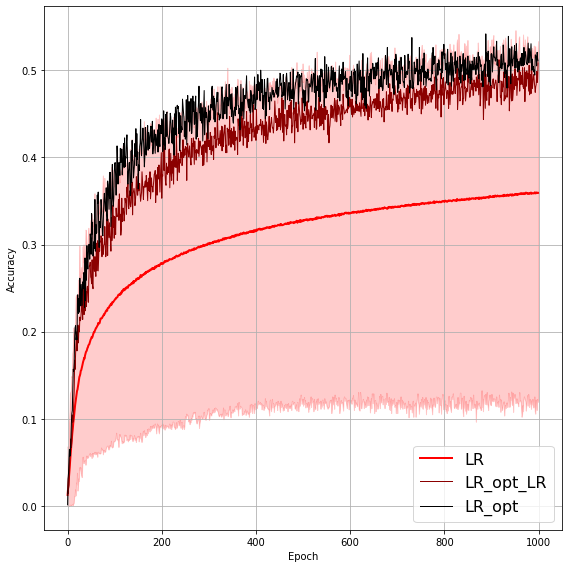

In [ ]:
#Model_list = ['LR', 'FFNN', 'Alexnet', 'GCNN', 'ODE_Lin', 'ODE_Graph']
#Color_list = ['r', 'g', 'b', 'c', 'm', 'y']
Model_list = ['LR']
Color_list = ['r']
plt.figure(figsize=(8,8))
plt.grid()
for model_name, color in zip(Model_list, Color_list):
    M = stack(pict, model_name).mean(0)
    D = torch.max(stack(pict, model_name), dim=0)[0]
    P = torch.min(stack(pict, model_name), dim=0)[0]
    plt.plot(torch.arange(len(M)), M, color , lw = 2, zorder = 9, label=model_name)
    plt.plot(acc_LR[model_name], 'darkred' , lw = 1, zorder = 9, label=model_name+'_opt'+'_LR')
    plt.plot(accuracy[model_name], 'k' , lw = 1, zorder = 9, label=model_name+'_opt')
    plt.fill_between(torch.arange(len(M)), D, P, alpha = 0.2, color=color)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
plt.legend(loc="lower right", prop={'size': 16})
plt.tight_layout()
plt.show()